In [1]:
pip install tensorflow numpy pandas matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import scipy.io
import numpy as np

# Load the MATLAB file
mat = scipy.io.loadmat('part_7.mat')

# Inspect the keys to find the data
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [3]:
data = mat['p']
print(type(data))
print(data.shape)
print(data.dtype)

<class 'numpy.ndarray'>
(1, 1000)
object


In [4]:
# Inspect the first element in the array
first_element = data[0, 0]  # Accessing the object inside the array
print(type(first_element))
print(first_element)

<class 'numpy.ndarray'>
[[ 0.52199413  0.50733138  0.49462366 ...  0.42619746  0.46725318
   0.5083089 ]
 [67.47070891 67.07957437 66.68843982 ... 85.46289795 85.07176341
  84.68062887]
 [ 0.47058824  0.39019608  0.3        ...  0.57058824  0.56470588
   0.57058824]]


In [5]:
# Extract the signals
ppg = first_element[0, :]  # PPG SIGNAL 
abp = first_element[1, :]  # ABP SIGNAL (we can ignore this column)
ecg = first_element[2, :]  # ECG SIGNAL

print (ppg.shape)
print (ecg.shape)

# Print the first few elements to verify
print("PPG Signal:", ppg[:5])
print("ABP Signal:", abp[:5])
print("ECG Signal:", ecg[:5])

(5000,)
(5000,)
PPG Signal: [0.52199413 0.50733138 0.49462366 0.48484848 0.47507331]
ABP Signal: [67.47070891 67.07957437 66.68843982 66.29730528 66.10173801]
ECG Signal: [0.47058824 0.39019608 0.3        0.28431373 0.27843137]


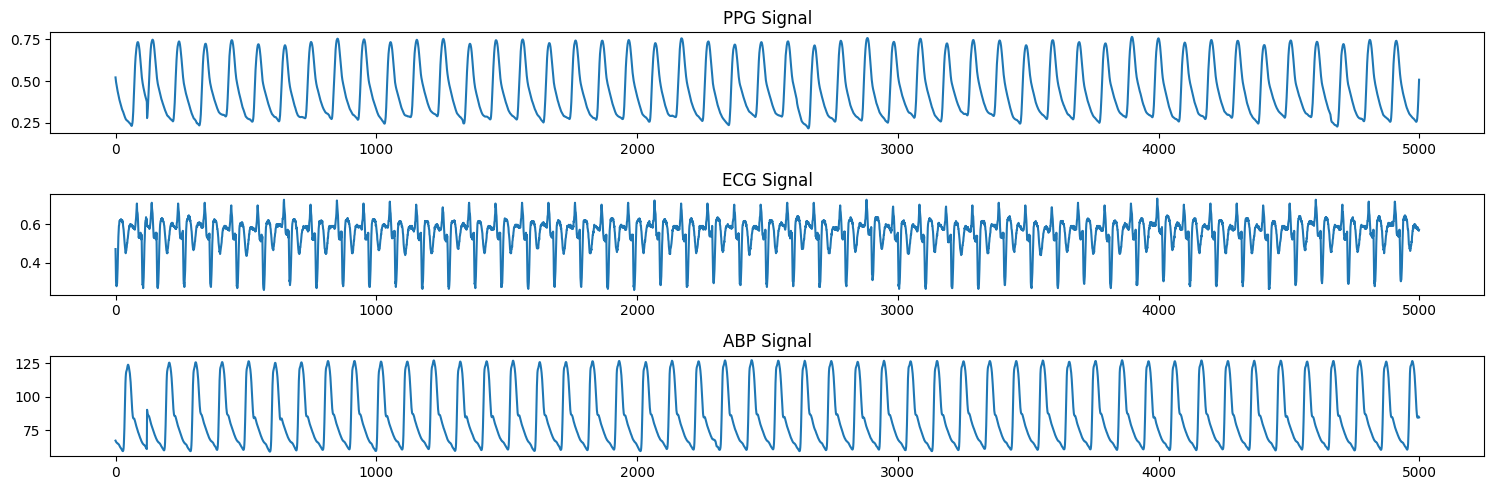

In [6]:
import matplotlib.pyplot as plt

# Plot the data points of each signal
plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.plot(ppg)
plt.title('PPG Signal')

plt.subplot(3, 1, 2)
plt.plot(ecg)
plt.title('ECG Signal')

plt.subplot(3, 1, 3)
plt.plot(abp)
plt.title('ABP Signal')

plt.tight_layout()
plt.show()

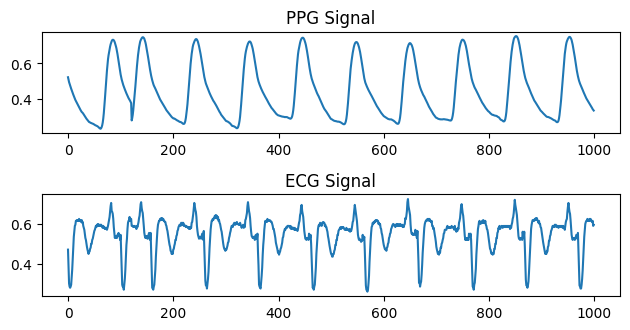

In [7]:
plt.subplot(3, 1, 1)
plt.plot(ppg[:1000])
plt.title('PPG Signal')

plt.subplot(3, 1, 2)
plt.plot(ecg[:1000])
plt.title('ECG Signal')

plt.tight_layout()
plt.show()

In [8]:
from scipy.signal import resample

# Assuming you want to resample to the ECG's length if they differ
ppg_resampled = resample(ppg, len(ecg))

# Or resample ECG to PPG's length
ecg_resampled = resample(ecg, len(ppg))

# Now both ppg_resampled and ecg_resampled should have the same length

Normalization


In [9]:
ppg_normalized = (ppg_resampled - ppg_resampled.min()) / (ppg_resampled.max() - ppg_resampled.min())
ecg_normalized = (ecg_resampled - ecg_resampled.min()) / (ecg_resampled.max() - ecg_resampled.min())

In [10]:
ppg_normalized

array([0.55714286, 0.53035714, 0.50714286, ..., 0.38214286, 0.45714286,
       0.53214286])

In [11]:
ecg_normalized

array([0.44813278, 0.2780083 , 0.08713693, ..., 0.65975104, 0.6473029 ,
       0.65975104])

 Segmenting the Data

In [12]:
window_size = 100  # Number of samples per segment
step_size = 100    # Non-overlapping window, use a smaller step_size for overlap

def segment_signal(signal, window_size, step_size):
    segments = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        segment = signal[start:start + window_size]
        segments.append(segment)
    return np.array(segments)

ppg_segments = segment_signal(ppg_normalized, window_size, step_size)
ecg_segments = segment_signal(ecg_normalized, window_size, step_size)

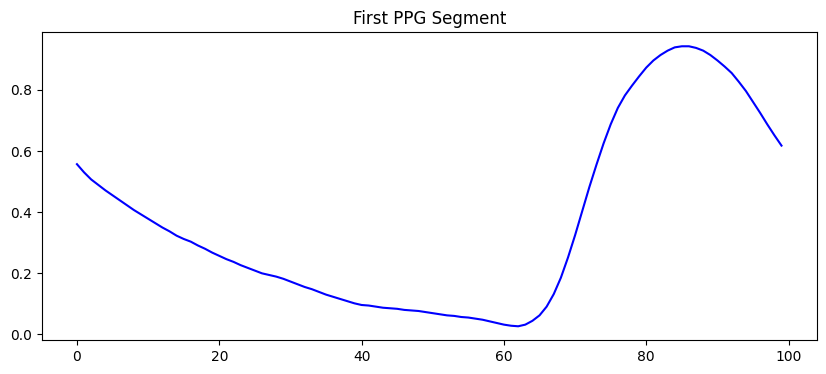

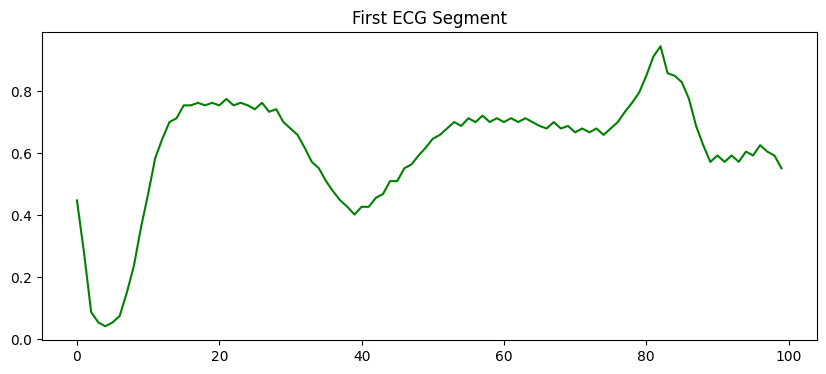

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(ppg_segments[0], color='blue')
plt.title('First PPG Segment')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(ecg_segments[0], color='green')
plt.title('First ECG Segment')
plt.show()

 Building the CardioGAN Model

Generator (This model converts PPG to ECG)


In [14]:
from tensorflow.keras import layers, Model

def build_generator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Add convolutional layers
    x = layers.Conv1D(32, kernel_size=3, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv1D(1, kernel_size=3, strides=1, padding="same")(x)
    outputs = layers.Activation("tanh")(x)
    
    return Model(inputs, outputs)

generator = build_generator((window_size, 1))
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 1)         │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

Discriminator (This model evaluates whether the ECG signal is real or generated)

In [15]:
def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv1D(32, kernel_size=3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    outputs = layers.Activation("sigmoid")(x)
    
    return Model(inputs, outputs)

discriminator = build_discriminator((window_size, 1))
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729 (6.75 KB)

 Trainable params: 1,729 (6.75 KB)

 Non-trainable params: 0 (0.00 B)

Combining the Models to Form CardioGAN
(Combine the Generator and Discriminator into the CardioGAN framework)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Discriminator training will be disabled when training the generator
discriminator.trainable = False

input_signal = layers.Input(shape=(window_size, 1))
generated_signal = generator(input_signal)
discriminator_output = discriminator(generated_signal)

combined_model = Model(input_signal, discriminator_output)
combined_model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy")

# Compile the Discriminator
discriminator.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

combined_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 100, 1)         │           225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 1)              │         1,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,954 (7.63 KB)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 1,729 (6.75 KB)

Training the Model

Train the CardioGAN with PPG segments as input and real ECG segments as output

In [17]:
# Check GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [18]:
# Number of samples in a batch
batch_size = 64
epochs = 1000

# Create labels for real (1) and fake (0)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, len(ppg_segments), batch_size)
    real_ecg_batch = ecg_segments[idx]
    ppg_batch = ppg_segments[idx]
    
    # Generate fake ECG from PPG using the Generator
    generated_ecg = generator.predict(ppg_batch)
    
    # Ensure the batch sizes match (sanity check)
    assert real_ecg_batch.shape[0] == batch_size
    assert generated_ecg.shape[0] == batch_size
    
    # Train the Discriminator on real and fake ECGs
    d_loss_real = discriminator.train_on_batch(real_ecg_batch, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_ecg, fake_labels)
    
    # Calculate the average loss for the Discriminator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train the Generator via the combined model
    g_loss = combined_model.train_on_batch(ppg_batch, real_labels)
    
    # Logging progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

# Implement Early Stopping or Save Model Checkpoints if necessary
from tensorflow.keras.callbacks import EarlyStopping

# Set early stopping based on validation MAE
from tensorflow.keras.callbacks import EarlyStopping
  
early_stopping = EarlyStopping(monitor='loss', patience=10)

callbacks = [early_stopping]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


C:\Users\Kunal Rane\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0, Discriminator Loss: [0.67472625 0.73828125], Generator Loss: [array(0.68285465, dtype=float32), array(0.68285465, dtype=float32), array(0.6015625, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [19]:
# Saving the generator model
generator.save('cardioGAN.keras')

In [20]:
# Saving the generator model in .h5 format
generator.save('cardioGAN.h5', save_format='h5')

import keras
from tensorflow.keras.models import load_model
# Loading the generator model from .h5 format
generator = keras.models.load_model('cardioGAN.h5')

Batch wise generated_ecg and batch wise real_ecg_batch (it shoud be 64)

In [21]:
# Remove the last dimension from generated_ecg
generated_ecg = np.squeeze(generated_ecg, axis=-1)

#  Check the shapes
print(f"Generated ECG shape: {generated_ecg.shape}")
print(f"PPG Batch shape: {ppg_batch.shape}")
print(f"Real ECG Batch shape: {real_ecg_batch.shape}")

Generated ECG shape: (64, 100)
PPG Batch shape: (64, 100)
Real ECG Batch shape: (64, 100)


Visualize the all the batches signals

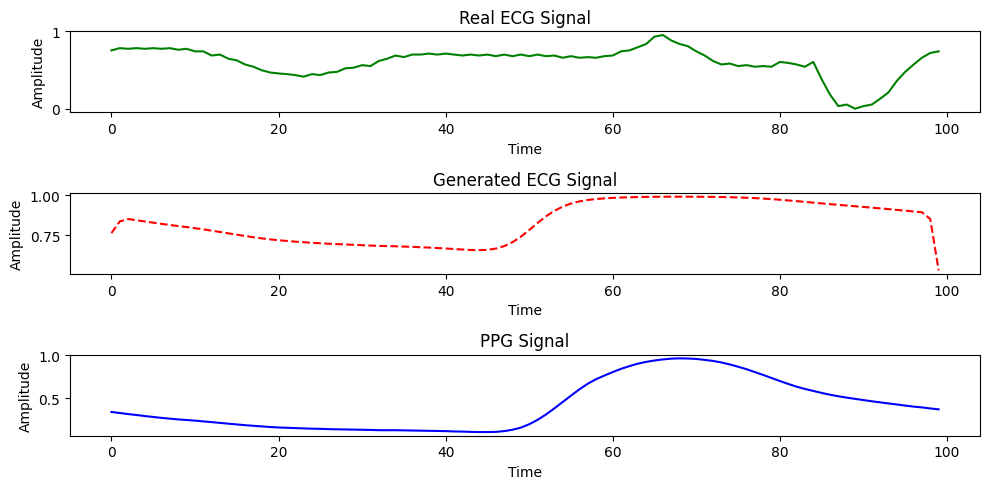

In [22]:
import matplotlib.pyplot as plt

# Select a sample index for visualization
sample_index = 0  # Choose an index within the batch

# Plotting the signals
plt.figure(figsize=(10, 5))

# Generated ECG
plt.subplot(3, 1, 2)
plt.plot(generated_ecg[sample_index], color='red', linestyle='dashed', label='CardioGan Generated ECG')
plt.title('Generated ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# PPG Signal
plt.subplot(3, 1, 3)
plt.plot(ppg_batch[sample_index], color='blue', label='PPG Signal')
plt.title('PPG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Real ECG
plt.subplot(3, 1, 1)
plt.plot(real_ecg_batch[sample_index], color='green', label='Real ECG')
plt.title('Real ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(real_ecg_batch, generated_ecg)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(real_ecg_batch, generated_ecg)
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 0.23677080342683296
Mean Squared Error (MSE): 0.1020240911425654


Now Predicting ECG for the Entire PPG Segments

In [24]:
# Predict ECG signals for the entire PPG segments
generated_ecg_segments = generator.predict(ppg_segments)

# If necessary, remove the extra dimension
generated_ecg_segments = np.squeeze(generated_ecg_segments, axis=-1)

# Verify the shape
print(f"Generated ECG segments shape: {generated_ecg_segments.shape}")
print(f"PPG segments shape: {ppg_segments.shape}")
print(f"Real ECG shape: {ecg_segments.shape}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Generated ECG segments shape: (50, 100)
PPG segments shape: (50, 100)
Real ECG shape: (50, 100)


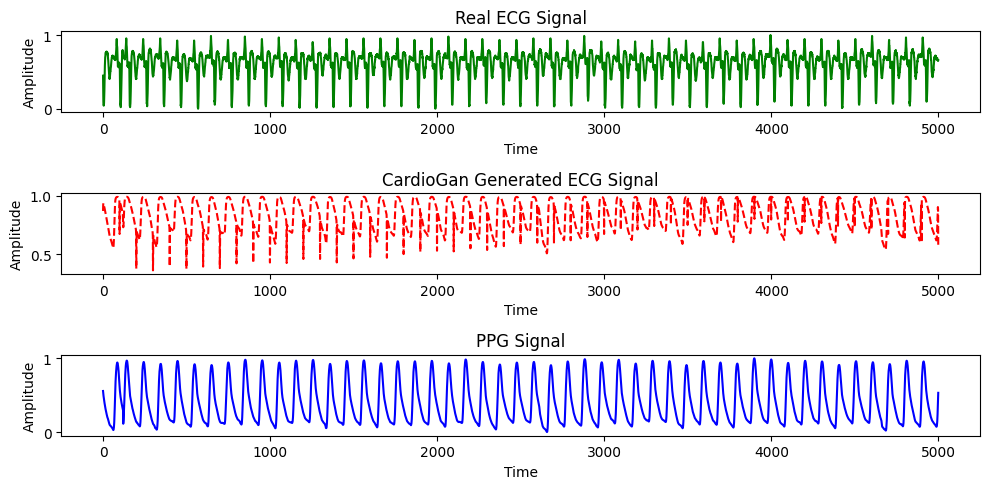

In [31]:
import matplotlib.pyplot as plt

# Define the number of samples to plot (you might want to plot a subset if too large)
num_samples_to_plot = 50   # Adjust this number as needed

# Plotting the signals
plt.figure(figsize=(10, 5))

# Real ECG
plt.subplot(3, 1, 1)
plt.plot(ecg_segments[:num_samples_to_plot].flatten(), color='green', label='Real ECG')
plt.title('Real ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# PPG Signal
plt.subplot(3, 1, 3)
plt.plot(ppg_segments[:num_samples_to_plot].flatten(), color='blue', label='PPG Signal')
plt.title('PPG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Generated ECG
plt.subplot(3, 1, 2)
plt.plot(generated_ecg_segments[:num_samples_to_plot].flatten(), linestyle='dashed', color='red', label='Generated ECG')
plt.title('CardioGan Generated ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(ecg_segments, generated_ecg_segments)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(ecg_segments, generated_ecg_segments)
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 0.2347739230676064
Mean Squared Error (MSE): 0.10025433769444334
